In [1]:
import json, sys
import cv2
import numpy as np

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines)
{
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import csv
import pandas as pd

anw_tsv = "CustomDataset/custom_dataset.tsv"

# Key - task id; Value - dictionary <worker_id, anw>
all_rows = []

data = pd.read_csv(anw_tsv, sep='\t', quotechar='"', doublequote=True, quoting=csv.QUOTE_NONNUMERIC)
data = data[['INPUT:image', 'OUTPUT:result']]

In [4]:
data

,INPUT:image,OUTPUT:result
0,/techtoker/14_09_2021_09_52_32.667114_crop.png,"[{""type"":""polygon"",""data"":[{""x"":0.99899,""y"":0...."
1,/techtoker/14_09_2021_09_56_29.393779_crop.png,"[{""type"":""polygon"",""data"":[{""x"":0.79724,""y"":0...."
2,/techtoker/14_09_2021_09_54_09.151941_crop.png,"[{""type"":""polygon"",""data"":[{""x"":0.83131,""y"":0...."
3,/techtoker/14_09_2021_09_59_43.876935_crop.png,"[{""type"":""polygon"",""data"":[{""x"":0.87521,""y"":0...."
4,/techtoker/14_09_2021_10_00_23.116072_crop.png,"[{""type"":""polygon"",""data"":[{""x"":0.5083,""y"":0.2..."
...,...,...
2379,/inno/30_09_2021_17_10_33_770_crop.png,"[{""type"":""polygon"",""data"":[{""x"":1.6E-4,""y"":0.4..."
2380,/inno/30_09_2021_17_11_46_952_crop.png,"[{""type"":""polygon"",""data"":[{""x"":0.09172,""y"":0...."
2381,/inno/30_09_2021_17_10_34_781_crop.png,"[{""type"":""polygon"",""data"":[{""x"":0.00123,""y"":0...."
2382,/inno/30_09_2021_17_07_19_553_crop.png,"[{""type"":""polygon"",""data"":[{""x"":0.07208,""y"":0...."


In [5]:
index = 1000

img = data.iloc[index][0]
polygon_json = data.iloc[index][1]

In [6]:
polygon_list = json.loads(polygon_json)
polygon_list

[{'type': 'polygon',
  'data': [{'x': 0.45149, 'y': 0.06695},
   {'x': 0.30411, 'y': 0.15078},
   {'x': 0.00027, 'y': 0.32315},
   {'x': 0.00012, 'y': 0.33158},
   {'x': 0.22719, 'y': 0.20043},
   {'x': 0.43335, 'y': 0.08077},
   {'x': 0.44347, 'y': 0.07369}]},
 {'type': 'polygon',
  'data': [{'x': 0.4629, 'y': 0.07074},
   {'x': 0.00243, 'y': 0.78566},
   {'x': 0.00162, 'y': 0.84157},
   {'x': 0.46151, 'y': 0.0759}]},
 {'type': 'polygon',
  'data': [{'x': 0.48509, 'y': 0.0823},
   {'x': 0.55862, 'y': 0.25738},
   {'x': 0.87238, 'y': 0.99686},
   {'x': 0.93146, 'y': 0.99843},
   {'x': 0.57291, 'y': 0.2601},
   {'x': 0.48569, 'y': 0.07695}]},
 {'type': 'polygon',
  'data': [{'x': 0.00055, 'y': 0.19772},
   {'x': 0.32332, 'y': 0.09969},
   {'x': 0.32252, 'y': 0.10325},
   {'x': 0.00055, 'y': 0.20314}]}]

In [7]:
source_img_folder_path = 'CustomDataset/source'

def get_source_img_name(name_in_data):
    # Remove prefix
    crop_img_name = name_in_data.rsplit('/', 1)[-1]
    
    return crop_img_name

def get_source_img_full_path(name_in_data):
    source_img_name = get_source_img_name(name_in_data)
    return f"{source_img_folder_path}/{source_img_name}"

In [8]:
source_img_path = get_source_img_full_path(img)
source_img_path

'CustomDataset/source/08_10_2021_18_04_32_673_crop.png'

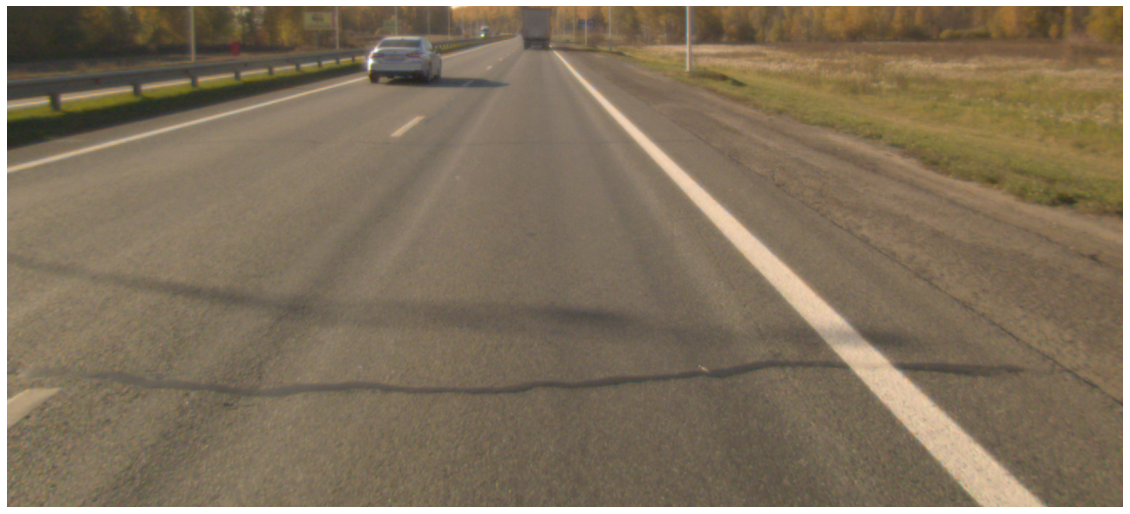

In [9]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

def show_img(img):
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

source_img = mpimg.imread(source_img_path)
show_img(source_img)

In [10]:
SOURCE_IMAGE_WIDTH = 1280
SOURCE_IMAGE_HEIGHT = 1024 - 450 # - crop size

FINAL_IMAGE_WIDTH = 640
FINAL_IMAGE_HEIGHT = 360

In [11]:
def get_polygon_pixel_vertexes(percentage_vertexs):
    pixel_vertexs = []
    
    for cord in percentage_vertexs:
        # Convert to source image persentage
        source_img_perc_x = cord['x']
        source_img_perc_y = cord['y']
                
        x = int(round(source_img_perc_x * SOURCE_IMAGE_WIDTH))
        y = int(round(source_img_perc_y * SOURCE_IMAGE_HEIGHT))
        
        pixel_vertexs.append([x, y])
        
    return pixel_vertexs

In [12]:
def get_all_polygons(pylygon_list):
    pixels_polygons = []
    
    for polygon in pylygon_list:
        points = get_polygon_pixel_vertexes(polygon['data'])
        
        pixels_polygons.append(points)
        
    return pixels_polygons

In [43]:
import os


def show_img_with_labels(index, show_imgs = False):
    img_name = data.iloc[index][0]
    polygon_json = data.iloc[index][1]
    
    polygon_list = json.loads(polygon_json)
    polygons = get_all_polygons(polygon_list)
    
    # Get images
    source_img_name = get_source_img_name(img_name)
    source_img_full_path = get_source_img_full_path(img_name)
    
    if not os.path.isfile(source_img_full_path):
        print(f'Miss file: {source_img_full_path}')
        return None, None
    
    source_img = mpimg.imread(source_img_full_path)
    debug_img = source_img.copy()
    
#     show_img(source_img)
#     print(source_img_full_path)
    blank_image = np.zeros((len(source_img), len(source_img[0])), np.uint8)
    
    
    # Draw all polygons on image
    for polygon in polygons:
        polygon = np.array([polygon], np.int32)
        
        debug_img = cv2.polylines(debug_img, [polygon], True, (0, 0.5, 0), thickness=1)
        blank_image = cv2.fillPoly(blank_image, [polygon], 1)
        
        
    if show_imgs:
        show_img(debug_img)
        show_img(blank_image)
    
    return source_img, debug_img, blank_image

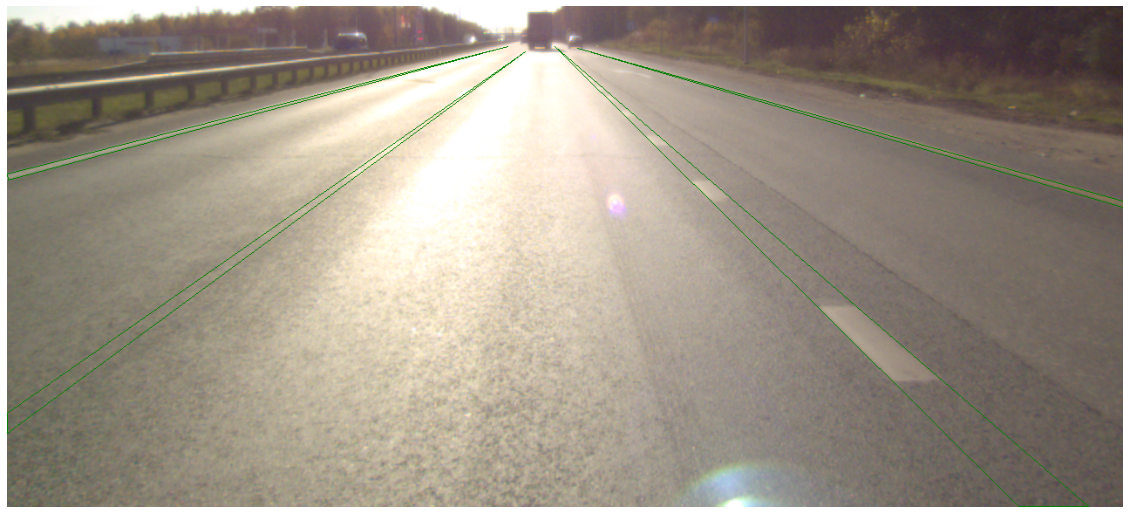

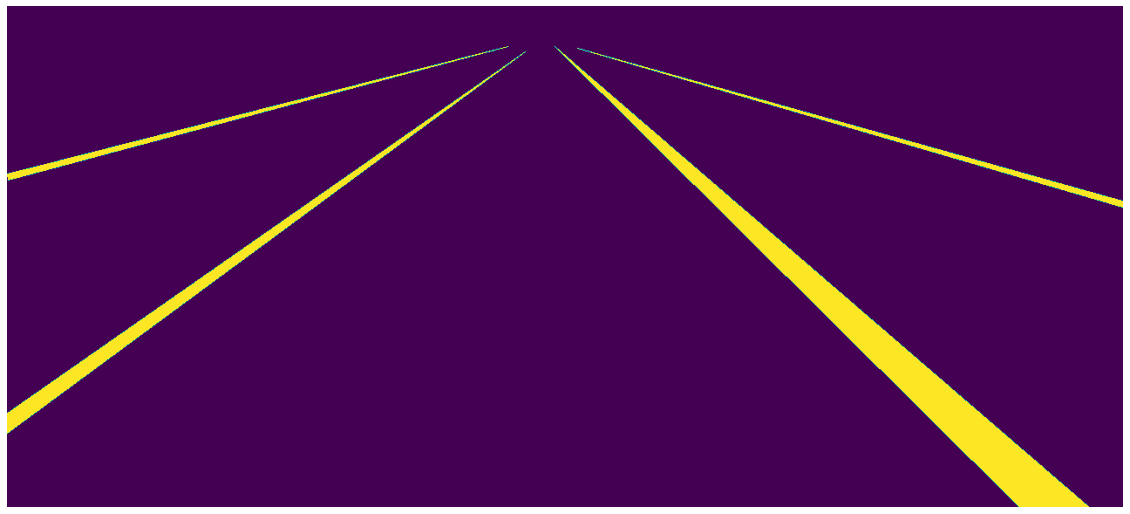

In [44]:
a, b, c = show_img_with_labels(2258, True)

Train/Val/Test split

In [45]:
# Randomize data before split

# TODO : Not randomizer; Sort by date, and sent to test every N-frame
# Thats need to send at least one test frames from every scene context
data = data.sample(frac=1).reset_index(drop=True)

In [46]:
valid_df = data[0:400]
test_df = data[401: 800]

train_df = data[800:]

In [47]:
train_df

,INPUT:image,OUTPUT:result
800,/inno/08_10_2021/08_10_2021_16_23_00_072_crop.png,"[{""type"":""polygon"",""data"":[{""x"":0.00568,""y"":0...."
801,/inno/08_10_2021/08_10_2021_18_01_39_770_crop.png,"[{""type"":""polygon"",""data"":[{""x"":1.8E-4,""y"":0.2..."
802,/inno/08_10_2021/08_10_2021_17_33_43_363_crop.png,"[{""type"":""polygon"",""data"":[{""x"":0.46337,""y"":0...."
803,/inno/30_09_2021/30_09_2021_18_16_27_559_crop.png,"[{""type"":""polygon"",""data"":[{""x"":0.07866,""y"":0...."
804,/inno/30_09_2021/30_09_2021_17_13_19_961_crop.png,"[{""type"":""polygon"",""data"":[{""x"":0,""y"":0.61831}..."
...,...,...
2379,/inno/30_09_2021/30_09_2021_18_33_41_601_crop.png,"[{""type"":""polygon"",""data"":[{""x"":0.82031,""y"":0...."
2380,/inno/08_10_2021/08_10_2021_16_37_14_789_crop.png,"[{""type"":""polygon"",""data"":[{""x"":0.0493,""y"":0.9..."
2381,/inno/08_10_2021/08_10_2021_17_15_45_803_crop.png,"[{""type"":""polygon"",""data"":[{""x"":9.8E-4,""y"":0.4..."
2382,/techtoker/14_09_2021_09_55_05.408919_crop.png,"[{""type"":""polygon"",""data"":[{""x"":0.78345,""y"":0...."


In [54]:
import tqdm
import os

def generate_data_split(df, prefix):
    output_source_path = f'CustomDataset/{prefix}'
    output_labels_path = f'CustomDataset/{prefix}_labels'
    
    os.makedirs(output_source_path)
    os.makedirs(output_labels_path)
    
    for i in tqdm.tqdm(range(len(df))):
        source, debug, label = show_img_with_labels(i)

        if debug is None or label is None:
            miss_count += 1
            continue

        label = cv2.convertScaleAbs(label, alpha=(255.0))

        name = data.iloc[i][0]

        name = name.rsplit('/', 1)[-1]

        source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
        
        cv2.imwrite(os.path.join(output_source_path, name), 255*source)
        cv2.imwrite(os.path.join(output_labels_path, name), label)

In [55]:
generate_data_split(train_df, 'train')

100%|██████████████████████████████████████████████████████████████████████████████| 1584/1584 [01:41<00:00, 15.66it/s]


In [56]:
generate_data_split(valid_df, 'valid')

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:24<00:00, 16.44it/s]


In [57]:
generate_data_split(test_df, 'test')

100%|████████████████████████████████████████████████████████████████████████████████| 399/399 [00:24<00:00, 16.35it/s]
